In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torchvision import datasets



In [2]:
train_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_data = datasets.FashionMNIST('../data', train=False, download=True,
                      transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)
train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]

mask = np.ones(60000)
mask[train_idx] = 0

valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]

batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=True)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [3]:

class CnnNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "cnn"
        self.losses = []
        self.accuracies = []
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 10),
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [4]:

class FcNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "fcnn"
        self.losses = []
        self.accuracies = []
        
        self.linear_layers = nn.Sequential(
            nn.Linear(28*28, 600),
            nn.ReLU(inplace=True),
            nn.Linear(600, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
class MixNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = "mnn"
        self.losses = []
        self.accuracies = []
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 10),
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x


In [6]:
lossFct = nn.NLLLoss(reduction='sum')


In [7]:
def train(model, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = lossFct(output, target)
        loss.backward()
        optimizer.step()
        

def valid(model):
    valid_loss = 0
    model.eval()
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data 
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    model.losses.append(valid_loss)
    model.accuracies.append(1. * correct / len(valid_loader.dataset))
    
    return valid_loss, 1. * correct / len(valid_loader.dataset)


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    print('\n' + model.name + " test" + ' set: Total loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    return test_loss, 1. * correct / len(test_loader.dataset)
        

def fit(model, optimizer, nb_epochs = 50):
    best_model = model
    best_accuracy = 0
    for i in range(nb_epochs):
        train(model, optimizer)
        loss, accuracy = valid(model)
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy
    
    test(best_model)

In [13]:
cnn = CnnNet()
cnnOptimizer = SGD(cnn.parameters(), lr=0.001)
fit(cnn, cnnOptimizer, 100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



cnn test set: Total loss: 3266.4104, Accuracy: 88%



In [9]:
fcnn = FcNet()
fcOptimizer = Adam(fcnn.parameters(), lr=0.001)
fit(fcnn, fcOptimizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



fcnn test set: Total loss: 6401.2900, Accuracy: 89%



In [10]:
mnn = MixNet()
mnnOptimizer = Adam(mnn.parameters(), lr=0.002)
fit(mnn, mnnOptimizer)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



mnn test set: Total loss: 5168.2368, Accuracy: 90%



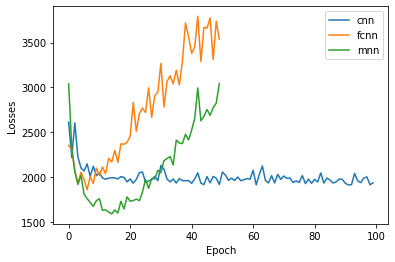

In [27]:
plt.plot(cnn.losses, label=cnn.name)
plt.plot(fcnn.losses, label=fcnn.name)
plt.plot(mnn.losses, label=mnn.name)
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.legend()
plt.show()

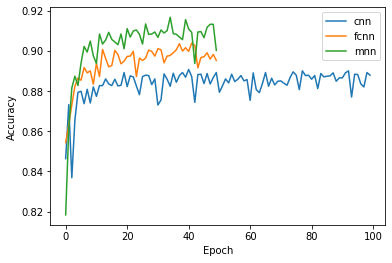

In [28]:
plt.plot(cnn.accuracies, label=cnn.name)
plt.plot(fcnn.accuracies, label=fcnn.name)
plt.plot(mnn.accuracies, label=mnn.name)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

